## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pysal.contrib.viz import mapping as maps
from shapely.geometry import Point, Polygon, shape
import re
from IPython.display import IFrame
from geopandas import GeoDataFrame
import shapely.speedups
from glob import glob
from shapely import wkt
from shapely.geometry.multipolygon import MultiPolygon
%matplotlib inline

crs = {'init': 'epsg:4326'}
amersfoort = {'init': 'epsg:28992'}
cea = {'proj': 'cea'}

C:\Users\LLaagwater\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


## datasets inladen

In [2]:
#import dataframes buurt
df_buurt = pd.read_csv("GEBIED_BUURTEN_EXWATER.csv",  delimiter=';')
df_buurt = df_buurt[df_buurt.Buurtcombinatie_code != 'N73']
df_buurt = df_buurt[df_buurt.Buurt_code != 'B10g']
df_buurt = df_buurt[df_buurt.Buurt_code != 'B10f']
df_buurt = df_buurt[df_buurt.Buurt_code != 'B10d']
df_buurt = df_buurt[df_buurt.Buurt_code != 'B10c']
df_buurt['buurt_oppervlakte'] = (df_buurt['Opp_m2']/1000000)
#convert dataframes into geodataframes
geometry = df_buurt['WKT_LNG_LAT'].apply(wkt.loads)
gdf_buurt = GeoDataFrame(df_buurt, crs=crs, geometry=geometry)
gdf_buurt = gdf_buurt.to_crs(amersfoort)
gdf_buurt.crs = amersfoort

In [3]:
# overlay amsterdam; hier maak ik de stadsgrenzen van Amsterdam aan
amsterdam = gdf_buurt.geometry.unary_union
df_amsterdam = pd.DataFrame([[amsterdam]])
df_amsterdam['geometry'] = ''
df_amsterdam['geometry'] = df_amsterdam.geometry.apply(lambda x: amsterdam)
df_amsterdam = df_amsterdam.drop([0], axis=1)
gdf_amst = GeoDataFrame(df_amsterdam, geometry='geometry')
gdf_amst.crs = amersfoort

In [248]:
# onbegroeid inladen
gdf_onbegroeid = gpd.read_file('bgt_onbegroeidterreindeel.GeoJSON')
# gdf_onbegroeid = gdf_onbegroeid.drop(['relatieveHoogteligging', 'LV-publicatiedatum', 'inOnderzoek', 'tijdstipRegistratie', 'namespace', 'lokaalID', 'bronhouder', 'bgt-status', 'plus-status', 'onbegroeidTerreindeelOpTalud', 'plus-fysiekVoorkomen', 'kruinlijnOnbegroeidTerreindeel', 'eindRegistratie', 'terminationDate'], axis=1)

In [249]:
# Braak inladen; braak gebieden zijn onbegroeide terreinen met het type onverhard.
gdf_braak = gdf_onbegroeid[gdf_onbegroeid['bgt-fysiekVoorkomen'] == 'onverhard']
gdf_braak = GeoDataFrame(gdf_braak, crs=amersfoort)
gdf_braak = gdf_braak.to_crs(cea)
gdf_braak.crs = cea
gdf_braak["oppervlakte"] = gdf_braak['geometry'].area/1000000
gdf_braak = gdf_braak.to_crs(amersfoort)
gdf_braak.crs = amersfoort

In [6]:
# Bomen inladen; hier worden ook de boomgroottes/oppervlaktes gedefineerd en alles in de goeie crs gezet.
def to_crs(gdf, crs=amersfoort):
    gdf = gdf.to_crs(crs)
    gdf.crs = crs
    return gdf

def create_gdf(df, crs=crs):
    gdf = GeoDataFrame(df, crs=crs, geometry=df.geometry.apply(wkt.loads))
    return to_crs(gdf, crs=amersfoort)
# groteboom_m2 
n1 = 18.7
# middelboom_m2 
n2 = 14.3
# kleineboom_m2 
n3 = 10.5
# microbosje
nbos = 280

bomen = pd.concat([pd.read_csv(file, sep=';', usecols=['Soortnaam_NL', 'Boomnummer', 'Boomtype', 'Boomhoogte', 'WKT_LNG_LAT']) 
                   for file in glob('Bomen\green-rooftops\data\BOMEN*.csv')], axis=0, ignore_index=True).rename(columns={'WKT_LNG_LAT':'geometry'})
bomen['geometry'] = bomen.geometry.str.replace(',', ' ')
bomen['aantal_bomen'] = 1
bomen['boomoppervlakte'] = np.where(bomen['Boomhoogte'].isin(['tot 6 m', '6-9 m', '9-12 m', 'Onbekend']), n3/1000000, 
                                    np.where(bomen['Boomhoogte'].isin(['12-15 m', '15-18 m']), n2/1000000, n1/1000000))
bomen = create_gdf(bomen)

In [7]:
# Panden inladen
pand = pd.read_csv('bomen\Buildings.csv', sep=',').drop(['Unnamed: 0'], axis = 1)
pand['geometry'] = pand['geometry'].apply(wkt.loads)
pand = GeoDataFrame(pand, crs=amersfoort)
pand['aantal_panden'] = 1
pand = pand.to_crs(cea)
pand.crs = cea
pand['pand_oppervlakte'] = pand['geometry'].area/1000000
pand = pand.to_crs(amersfoort)
pand.crs = amersfoort

In [8]:
# Bestemmingsplannen inladen en overlay met stadsgrenzen
gdf_bestemming = pd.read_csv("bestemmingsplan.csv",  delimiter=',')
gdf_bestemming['geometry'] = gdf_bestemming['geometry'].apply(wkt.loads)
gdf_bestemming = GeoDataFrame(gdf_bestemming, crs=crs)
gdf_bestemming = gdf_bestemming.to_crs(cea)
gdf_bestemming.crs = cea
gdf_bestemming['b_area'] = gdf_bestemming['geometry'].area/1000000
gdf_bestemming = gdf_bestemming.to_crs(amersfoort)
gdf_bestemming.crs = amersfoort
gdf_bestemming = gdf_bestemming[gdf_bestemming.Fase.isin(['Principebesluit genomen','Overkoepelend besluit genomen'])]
gdf_bestemming = gpd.overlay(gdf_bestemming, gdf_amst, how='intersection')

## Braak joinen op buurt

In [141]:
# Overlay buurten en bestemmingplannen; eerst alles binnen stadsgrenzen dan binnen buurten. 
# Vervolgens wordt alles binnen een bestemmingsplan eraf gehaald.
gdf_temp = gpd.overlay(gdf_braak, gdf_amst, how='intersection')
gdf_temp2 = gpd.overlay(gdf_braak, gdf_buurt, how='intersection')
dfg_braak_stad = gpd.overlay(gdf_temp2, gdf_bestemming, how='difference')

In [142]:
# nieuwe area uitrekenen (na overlay)
dfg_braak_stad = dfg_braak_stad.to_crs(cea)
dfg_braak_stad.crs = cea
dfg_braak_stad["oppervlakte"] = dfg_braak_stad['geometry'].area/1000000
dfg_braak_stad = dfg_braak_stad.to_crs(amersfoort)
dfg_braak_stad.crs = amersfoort
dfg_braak_stad['oppervlakte'].sum()
dfg_braak_stad = dfg_braak_stad.reset_index()
dfg_braak_stad['terrein_id'] = dfg_braak_stad['index']

## Objecten binnen stadsgrenzen

In [143]:
# Bomen & pand binnen stadsgrenzen doormiddel van een spacial join
bomen_stad = gpd.sjoin(bomen, dfg_braak_stad, how='inner', op='within').drop(['index_right', 'gml_id', 'creationDate', 'bgt-fysiekVoorkomen', 'oppervlakte', 'OBJECTNUMMER', 'Buurt_code', 'Buurt', 'Buurtcombinatie_code', 'Stadsdeel_code', 'buurt_oppervlakte', 'WKT_LNG_LAT', 'terrein_id','oppervlakte'], axis = 1)
pand_stad = gpd.sjoin(pand, gdf_buurt, how='inner', op='within').drop(['index_right', 'OBJECTNUMMER', 'Buurt_code', 'Buurt', 'Buurtcombinatie_code', 'Stadsdeel_code', 'buurt_oppervlakte', 'WKT_LNG_LAT', 'WKT_LAT_LNG', 'LNG', 'LAT', 'Unnamed: 10'], axis = 1)

## Test plot

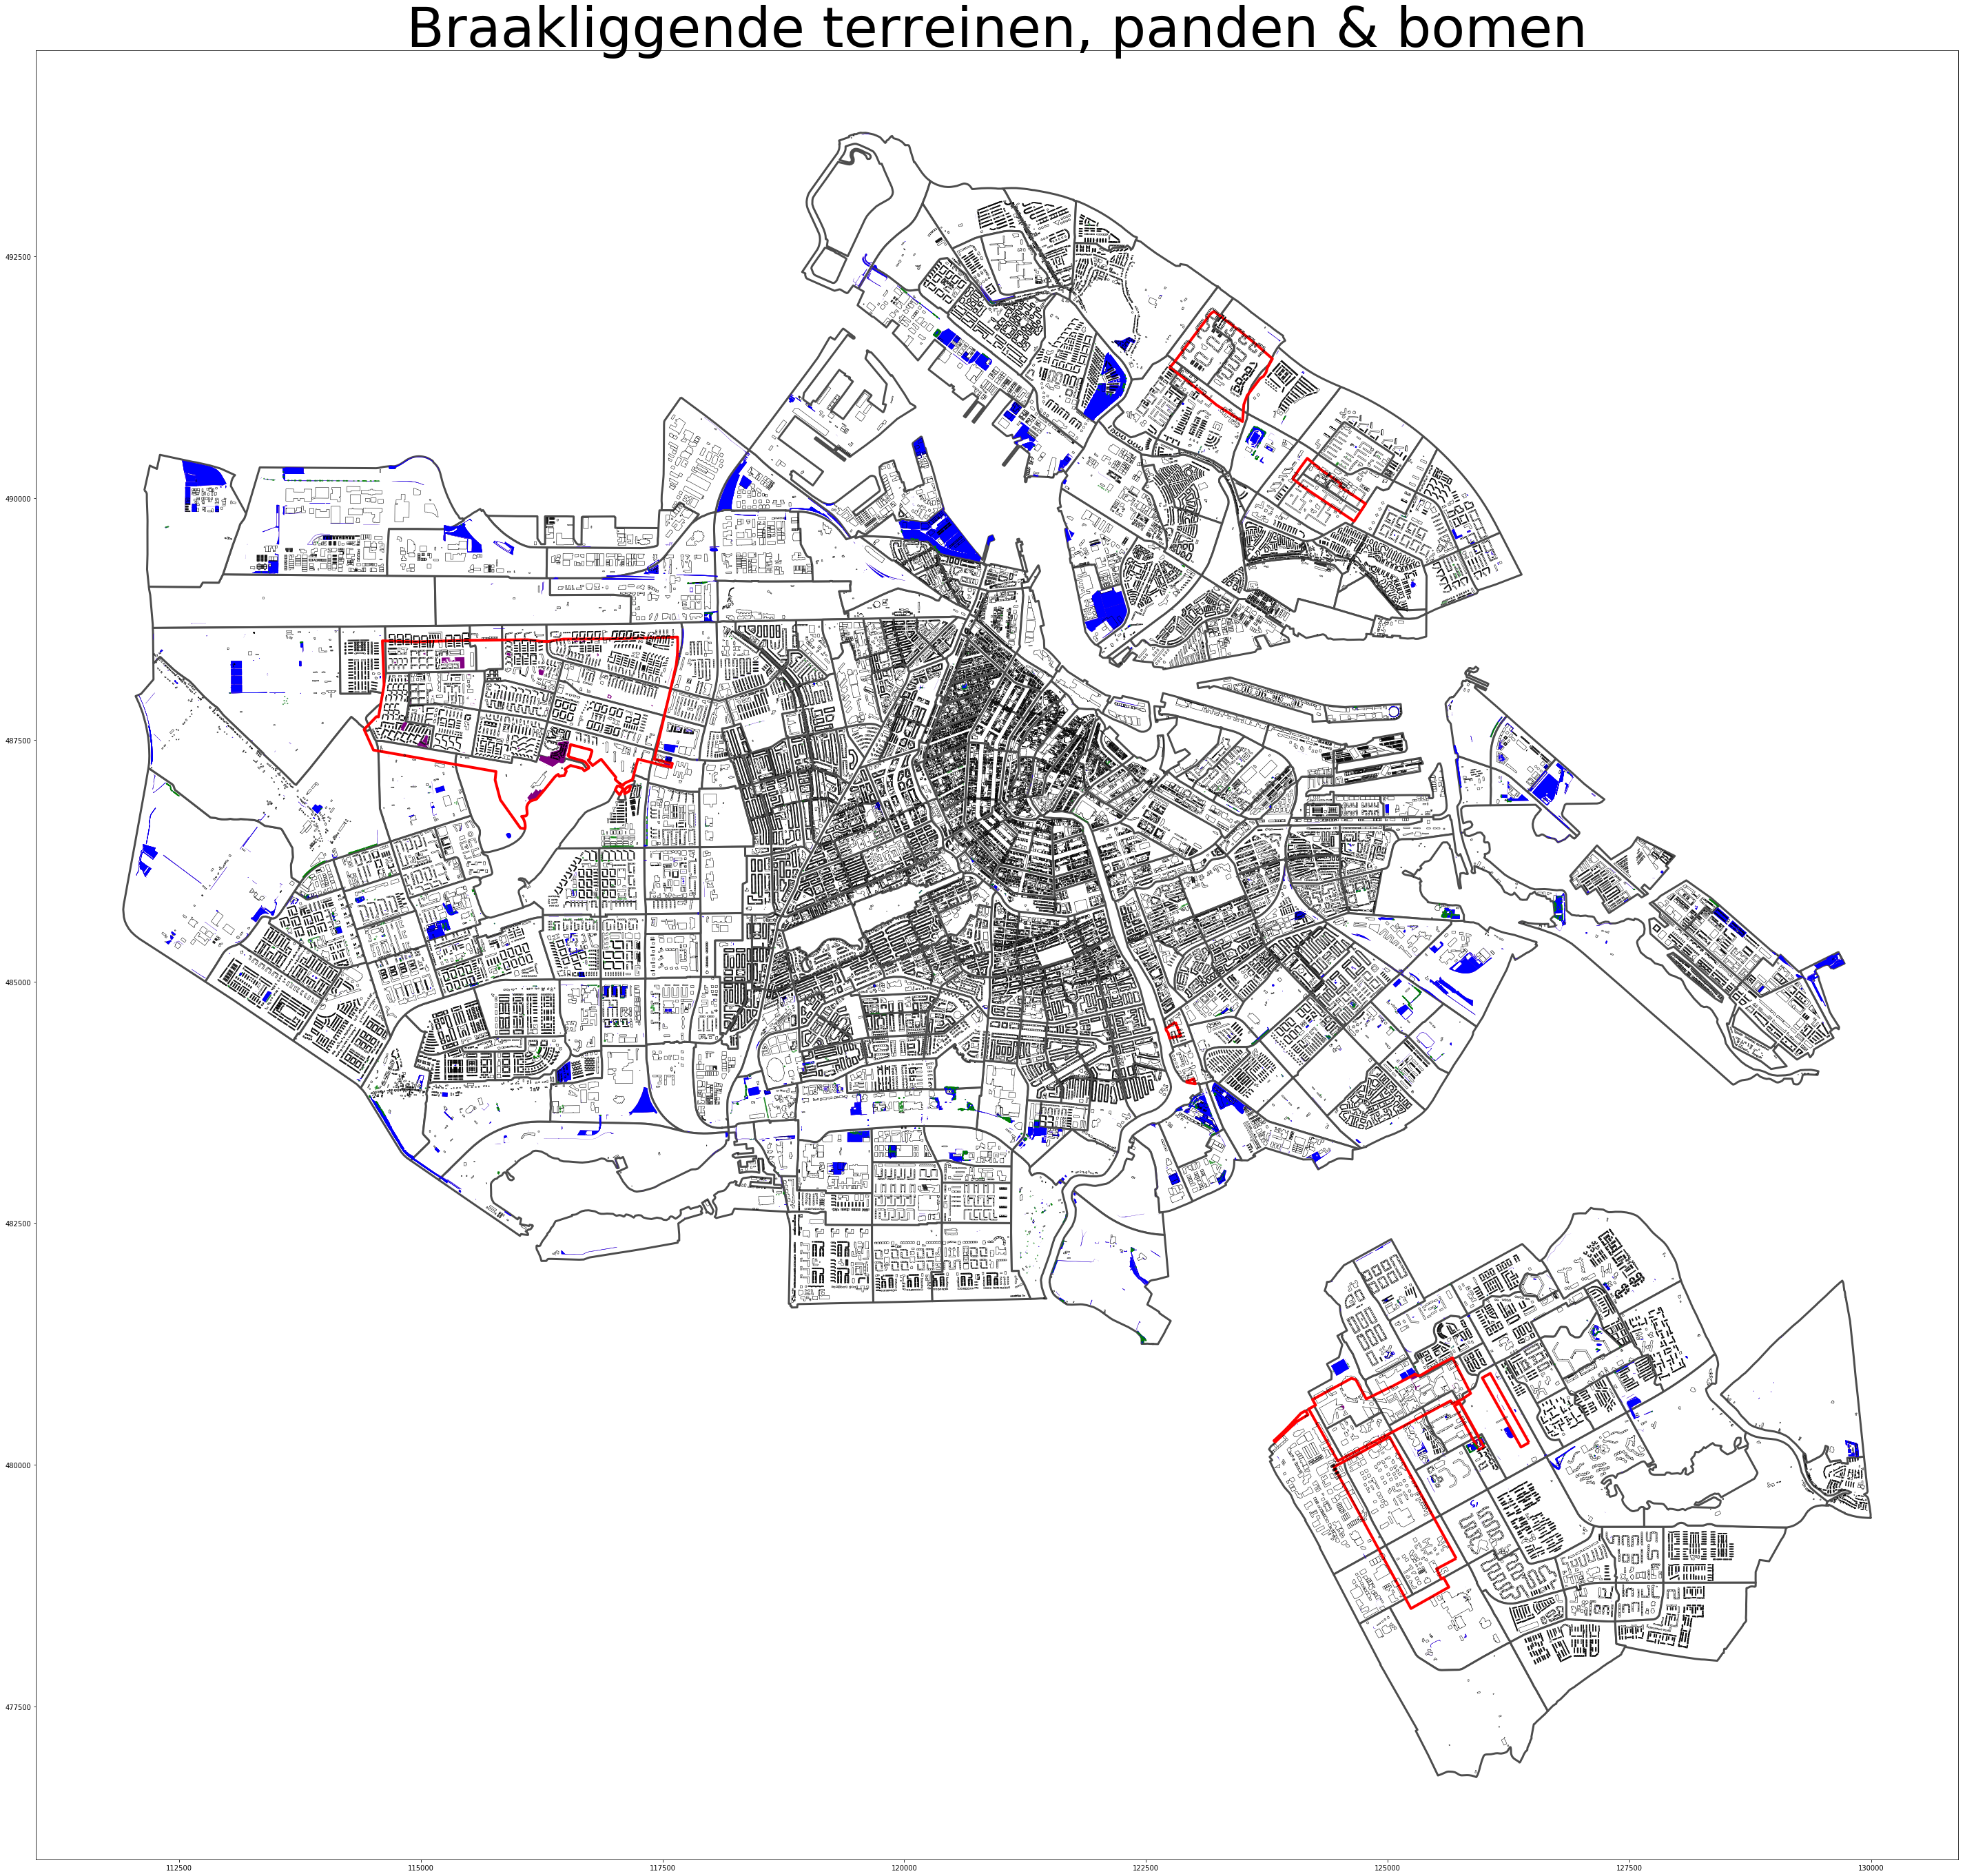

In [144]:
fig, ax = plt.subplots(1, figsize=(50, 60))
plt.title('Braakliggende terreinen, panden & bomen', size=80)
gdf_buurt.plot(linewidth=3, ax=ax, edgecolor='0.3', color='white')
gdf_temp2.plot(ax=ax, color='purple')
dfg_braak_stad.plot(ax=ax, color='blue', linewidth=5, markersize=20)
gdf_bestemming.plot(ax=ax, edgecolor='red', linewidth=4, facecolor='none')
pand_stad.plot(linewidth=0.5, ax=ax, edgecolor='black', facecolor='none')
bomen_stad.plot(ax=ax, linewidth=.5, edgecolor='green', facecolor='none', markersize=2)

## Joinen van braak met bomen en panden (uitrekenen oppervlakte objecten per braak)

In [196]:
# joinen van bomen en panden. Zo kan je zien hoeveel objecten er binnen een braak gebied vallen
gdf_braak_bomen = gpd.sjoin(dfg_braak_stad, bomen_stad, how='left', op='contains').groupby(['terrein_id']).sum()
gdf_braak_panden = gpd.sjoin(dfg_braak_stad, pand_stad, how='left', op='contains').groupby(['terrein_id']).sum()
gdf_braak_panden = gdf_braak_panden.reset_index()
gdf_braak_bomen = gdf_braak_bomen.reset_index()

## mergen van oppervlaktes + vrije ruimte uitrekenen

In [197]:
# Oppervlakte van braakliggende gebieden matchen aan die van bomen en panden.
# Eerst bomen en panden mergen, vervolgens mergen met het originele braak bestand voor het juiste oppervlakte.
gdf_braak_panden_bomen_temp = gdf_braak_bomen.merge(gdf_braak_panden, on=['terrein_id']).drop(['OBJECTNUMMER_x','area','buurt_oppervlakte_x','OBJECTNUMMER_y','buurt_oppervlakte_y', 'Unnamed: 10_left', 'Unnamed: 10_right', 'index_right_x', 'index', 'oppervlakte_y', 'Unnamed: 10', 'index_right_y'], axis=1)
gdf_braak_panden_bomen = dfg_braak_stad.merge(gdf_braak_panden_bomen_temp, on=['terrein_id']).drop(['index','Unnamed: 10'],axis=1)

# Vrije ruimte uitrekenen
gdf_braak_panden_bomen['vrije_ruimte'] = gdf_braak_panden_bomen['oppervlakte']-(gdf_braak_panden_bomen.boomoppervlakte + gdf_braak_panden_bomen.pand_oppervlakte)
gdf_braak_panden_bomen['vrije_ruimte'] = np.where(gdf_braak_panden_bomen['vrije_ruimte']<=0, 0,gdf_braak_panden_bomen['vrije_ruimte'])

## Te planten bomen uitrekenen

In [233]:
# Door de rest waarde uit te rekenen kan er gekeken worden hoeveel kleine/middel boven er nog geplaatst kunnen worden wanneer alle grote bomen geplant zijn.
gdf_braak_panden_bomen['rest'] = gdf_braak_panden_bomen['vrije_ruimte'] % (n1/1000000)
gdf_braak_panden_bomen['te_planten_grote_bomen'] = (gdf_braak_panden_bomen['vrije_ruimte'] - gdf_braak_panden_bomen['rest'])/(n1/1000000)
gdf_braak_panden_bomen['te_planten_grote_bomen'] = np.where(gdf_braak_panden_bomen['te_planten_grote_bomen']<1, 0,gdf_braak_panden_bomen['te_planten_grote_bomen'])
gdf_braak_panden_bomen['te_planten_grote_bomen'] = gdf_braak_panden_bomen['te_planten_grote_bomen'].astype(int).round(0)
gdf_braak_panden_bomen['te_planten_middel_bomen'] = np.where(gdf_braak_panden_bomen['rest'] >= (n2/1000000), 1,0)
gdf_braak_panden_bomen['te_planten_klein_bomen'] = np.where(np.logical_and(gdf_braak_panden_bomen['rest'] >= (n3/1000000), gdf_braak_panden_bomen['rest'] < (n2/1000000)), 1,0)
gdf_braak_panden_bomen['aantal_microbos'] = (gdf_braak_panden_bomen['te_planten_grote_bomen']/(nbos/n1)).astype(int).round(0)
gdf_braak_panden_bomen['te_planten_bomen_totaal'] = gdf_braak_panden_bomen['te_planten_klein_bomen'] + gdf_braak_panden_bomen['te_planten_middel_bomen'] + gdf_braak_panden_bomen['te_planten_grote_bomen'] 
gdf_braak_panden_bomen = gdf_braak_panden_bomen.drop(['rest'], axis=1)
gdf_braak_panden_bomen = gdf_braak_panden_bomen[gdf_braak_panden_bomen.te_planten_bomen_totaal > 0]

In [251]:
# Duplicaten weghalen
gdf_braak_panden_bomen['vrije_ruimte'] = gdf_braak_panden_bomen.vrije_ruimte.apply(round, ndigits=12)
gdf_braak_panden_bomen = gdf_braak_panden_bomen.drop_duplicates(subset='vrije_ruimte')

## Terrein top 10

In [236]:
terrein_top_10 = uniek.sort_values(['te_planten_bomen_totaal'], ascending=False).head(10).drop(['creationDate','OBJECTNUMMER','Buurt_code','Buurtcombinatie_code', 'WKT_LNG_LAT', 'WKT_LAT_LNG', 'LNG', 'LAT', 'oppervlakte', 'oppervlakte_x', 'Boomnummer', 'pand_id','Opp_m2_left_x', 'Opp_m2_left_y', 'Opp_m2_right_y', 'Opp_m2_right_x', 'Opp_m2' ], axis=1)
terrein_top_10.to_csv('Terreinen_top_10.csv')

In [237]:
terrein_top_10

gml_id bgt-fysiekVoorkomen  \
2325  bb69b18ae-5404-11e8-951f-610a7ca84980           onverhard   
2324  b69b4c36c-f521-11e8-80e2-b7dac308c237           onverhard   
2561  b5d7e78af-5401-11e8-a5a2-73a1868acdce           onverhard   
2550  b5d7e9fc0-5401-11e8-a5a2-73a1868acdce           onverhard   
2720  be0072ec6-70a2-11e8-a5a2-73a1868acdce           onverhard   
2401  bb69aca8a-5404-11e8-951f-610a7ca84980           onverhard   
3432  bdff442e2-70a2-11e8-a5a2-73a1868acdce           onverhard   
3934  bc011f52c-5402-11e8-951f-610a7ca84980           onverhard   
3196  b332b1f38-109b-11e9-92b3-89cb66b978d0           onverhard   
2410  b38f488d4-70a3-11e8-a5a2-73a1868acdce           onverhard   

                          Buurt Stadsdeel_code  buurt_oppervlakte  \
2325            Houthavens West              E           0.272660   
2324            Houthavens West              E           0.272660   
2561                 De Heining              F           1.125580   
2550                 De Heining              F           1.125580   
2720              Alfa-driehoek              B           0.406268   
2401            Houthavens West              E           0.272660   
3432  Zeeburgereiland Noordoost              M           0.234398   
3934                  Overhoeks              N           0.286859   
3196           Weespertrekvaart              M           0.482447   
2410                 De Bongerd              N           0.300161   

                                               geometry  terrein_id  \
2325  POLYGON ((120518.8349960289 489697.4904322593,...         758   
2324  POLYGON ((120531.5439960302 489569.0104322017,...         676   
2561  POLYGON ((112531.3759951104 490388.8364325105,...        6263   
2550  POLYGON ((112531.3759951104 490388.8364325105,...        3414   
2720  POLYGON ((118258.1399957695 490128.6264324388,...        6395   
2401  POLYGON ((120379.6779960126 489507.118432184, ...        8690   
3432  POLYGON ((126763.9519967444 487063.6974311998,...        4538   
3934  POLYGON ((122291.6189962317 488785.8384318934,...        1908   
3196  POLYGON ((123343.1919963446 483856.3964298946,...        1071   
2410  POLYGON ((122291.7349962357 491193.5204328601,...         460   

      aantal_bomen  boomoppervlakte  aantal_panden  pand_oppervlakte  \
2325           0.0         0.000000           70.0          0.012757   
2324           0.0         0.000000           64.0          0.006066   
2561           0.0         0.000000            0.0          0.000000   
2550           0.0         0.000000            0.0          0.000000   
2720           0.0         0.000000            0.0          0.000000   
2401          31.0         0.000460            0.0          0.000000   
3432           0.0         0.000000            0.0          0.000000   
3934           0.0         0.000000            1.0          0.002050   
3196          24.0         0.000276            6.0          0.005853   
2410          46.0         0.000483            1.0          0.002371   

      vrije_ruimte  te_planten_grote_bomen  te_planten_middel_bomen  \
2325      0.064568                    3451                        1   
2324      0.062658                    3350                        0   
2561      0.057397                    3069                        0   
2550      0.054664                    2923                        0   
2720      0.047113                    2519                        0   
2401      0.046714                    2498                        0   
3432      0.042011                    2246                        0   
3934      0.039944                    2136                        0   
3196      0.035379                    1891                        1   
2410      0.034536                    1846                        1   

      te_planten_klein_bomen  aantal_microbos  te_planten_bomen_totaal  
2325                       0              230                     3452  
2324                       1        

## Buurt top 10

In [252]:
buurt_top_10 = gdf_braak_panden_bomen.groupby(['Buurt']).sum().sort_values(['te_planten_bomen_totaal'], ascending=False).head(10).drop(['OBJECTNUMMER', 'terrein_id', 'Boomnummer', 'pand_id', 'oppervlakte_x', 'oppervlakte', 'Opp_m2_left_x', 'Opp_m2_right_x', 'Opp_m2_left_y', 'Opp_m2_right_y' ,'Opp_m2'], axis=1)
buurt_top_10.to_csv('buurten_top_10.csv')

In [253]:
gdf_braak_panden_bomen.vrije_ruimte.sum()

2.656723

## Aantal parkjes

In [254]:
# Aantal bomen dat een park vormt
parkgrootte = 500
aantal_parkjes = len(gdf_braak_panden_bomen[gdf_braak_panden_bomen.te_planten_bomen_totaal > parkgrootte])
aantal_parkjes

70

## Plots

In [255]:
# inladen stadsdelen
stadsdelen = pd.read_csv('GEBIED_STADSDELEN_EXWATER.csv', delimiter=';').rename(columns={'WKT_LNG_LAT': 'geometry'})
stadsdelen = GeoDataFrame(stadsdelen, crs=crs, geometry=stadsdelen.geometry.apply(wkt.loads))
stadsdelen = stadsdelen.to_crs(amersfoort)
stadsdelen.crs = amersfoort

In [256]:
# kies stadsdeel op index: {0=centrum, 1=westpoort, 2=zuidoost, 3=west, 4=nieuw-west, 5=oost, 6=zuid, 7=noord} 
deelindex = 4
gdf_braak_stadsdeel = gdf_braak_panden_bomen[gdf_braak_panden_bomen.geometry.within(stadsdelen.geometry[deelindex])]
gdf_buurt_stadsdeel= gdf_buurt[gdf_buurt.geometry.within(stadsdelen.geometry[deelindex])]
bomen_stadsdeel = bomen_stad[bomen_stad.geometry.within(stadsdelen.geometry[deelindex])]
panden_stadsdeel = pand_stad[pand_stad.geometry.within(stadsdelen.geometry[deelindex])]
temp_stadsdeel = gdf_temp2[gdf_temp2.geometry.within(stadsdelen.geometry[deelindex])] 
bestem_stadsdeel =  gpd.overlay(gdf_bestemming, stadsdelen[stadsdelen.index == deelindex], how='intersection')

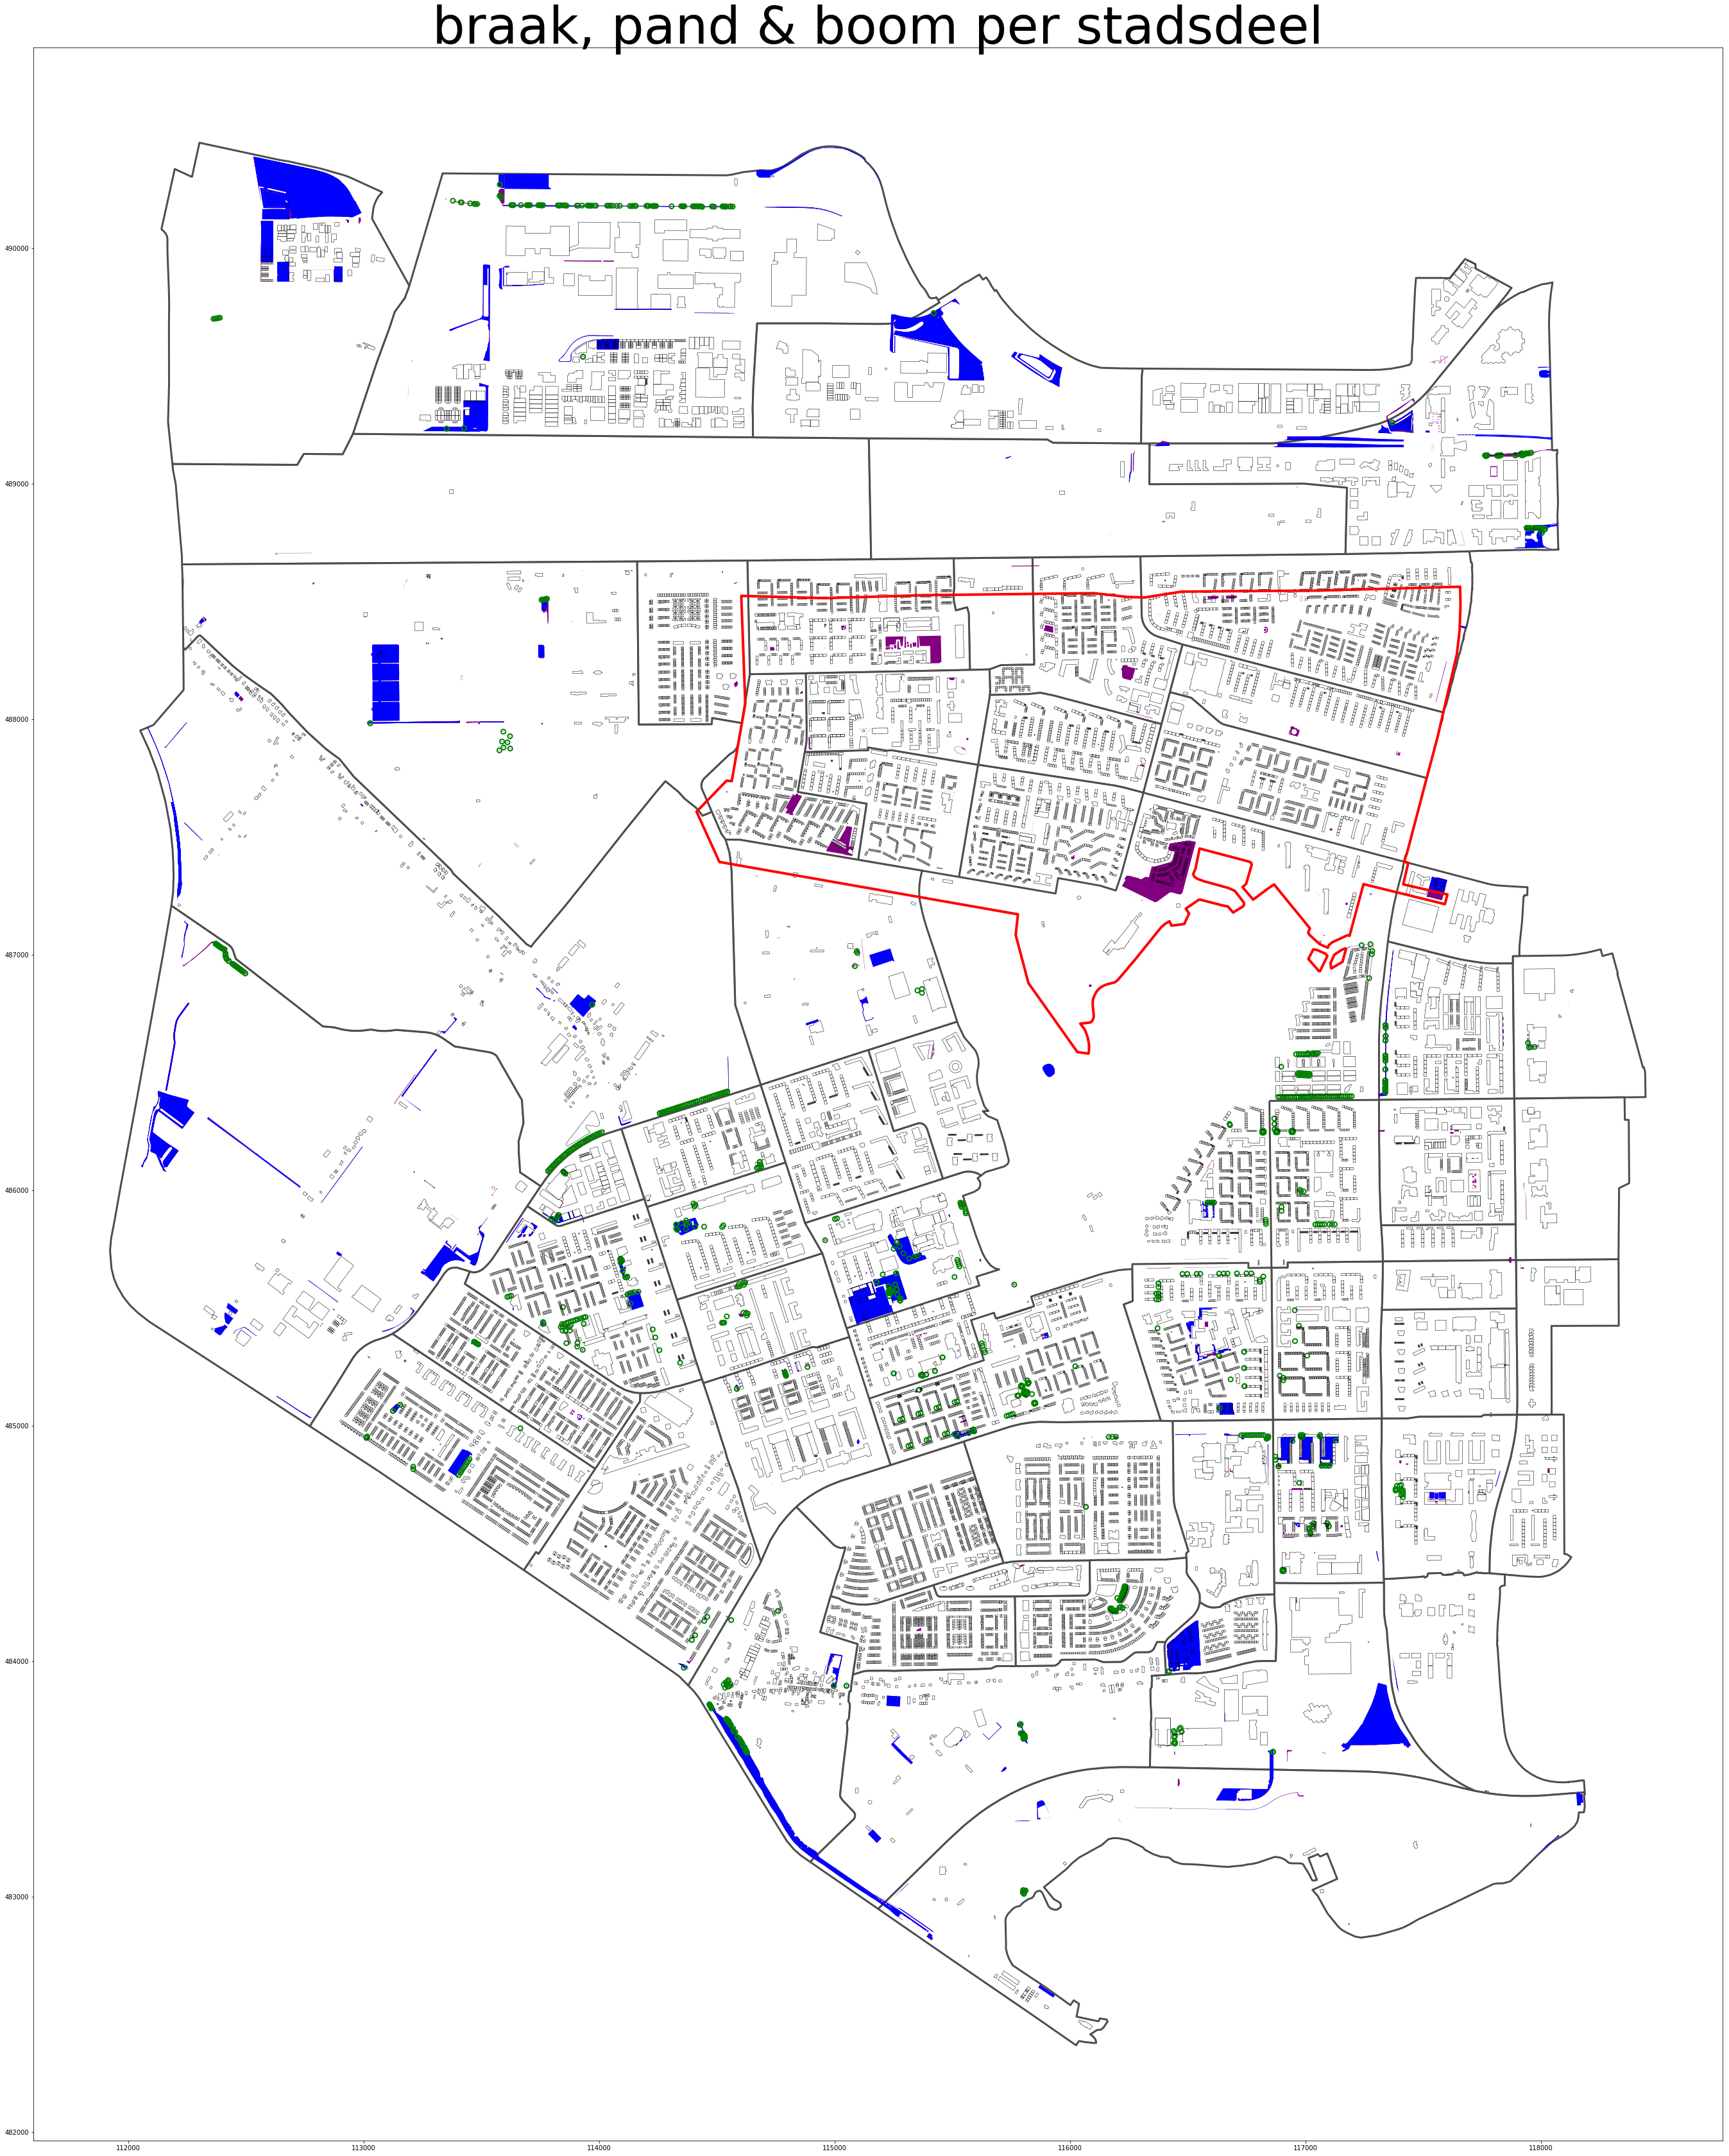

In [257]:
# Plot per stadsdeel 
fig, ax = plt.subplots(1, figsize=(50, 60))
plt.title('braak, pand & boom per stadsdeel', size=80)
gdf_buurt_stadsdeel.plot(linewidth=3, ax=ax, edgecolor='0.3', color='white')
temp_stadsdeel.plot(ax=ax, color='purple', linewidth=10, markersize=40)
gdf_braak_stadsdeel.plot(ax=ax, color='blue', linewidth=10, markersize=40)
bomen_stadsdeel.plot(linewidth=2, ax=ax, edgecolor='green', facecolor='none', markersize=50)
panden_stadsdeel.plot(linewidth=.5, ax=ax, edgecolor='black', facecolor='none')
bestem_stadsdeel.plot(ax=ax, edgecolor='red', linewidth=4, facecolor='none')

## Nieuwe bomen plot

In [169]:
import random
import shapely
import geopandas
import pandas as pd
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame, GeoSeries

# Definieer projecties
crs = {'init': 'epsg:4326'}          # Standaard WGS84
amersfoort = {'init': 'epsg:28992'}  # Rijkscoördinatendriehoek
cea = {'proj':'cea'}                 # Equal area

# Functies definiëren


def to_crs(gdf, crs_out=amersfoort):
    '''Returns a GeoDataFrame with coordinates projected as specified (default epsg:28992)'''
    gdf = gdf.to_crs(crs_out)  # Use geopandas built-in method
    gdf.crs = crs_out  # Set CRS property as well, just to be sure
    return gdf


def random_points_within(poly, k, min_dist=.5):
    
    '''Returns a list of lists of k random Point objects that are within poly, seperated by at least min_dist'''
    
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    i = 0
    
    while len(points) < k:
        
        # Pak een random punt op de x-as, en vind en een random punt op de y-as dat in het polygoon ligt
        try:
            x = random.uniform(min_x, max_x)
            x_line = LineString([(x, min_y), (x, max_y)])
            x_line_intercept_min, x_line_intercept_max = x_line.intersection(poly).xy[1].tolist()
            y = random.uniform(x_line_intercept_min, x_line_intercept_max)
        except:
            continue
        
        point = Point([x, y])
        
        # Controleer of de afstand van een nieuwe boom tot bestaande bomen kleiner is dan min_dist
        # Dit werkt nog niet goed wanneer min_dist te groot is
        dist = []
        gdf = GeoDataFrame(points, crs=cea)
        for i in range(len(gdf)):
            dist.append(gdf.iat[i, 0].distance(point) < min_dist)
        
        # Voeg de nieuwe boom toe, behalve als er een andere boom dichterbij ligt dan min_dist
        i += 1
        if sum(dist) == 0:
            points.append(point)
        elif i > k * 1:
            print(f'It was impossible to find enough points within poly with index:')
            return points
        else:
            continue
    
    return points


def random_points(row, colname='nieuwe_bomen', min_dist=.5):
    '''Returns a list of lists of random points, based on a geometry and a value of nieuwe_bomen in a GeoDataFrame'''
    print(f'{row.name}:\t{row["vrije_ruimte"]} km²')
    points = random_points_within(row['geometry'], row[colname], min_dist=min_dist)
    if len(points) < row[colname]:
        print(f'{row.name}\n')
    return points


def plant_trees(gdf, colname='nieuwe_bomen', min_dist=.5):
    '''Returns a GeoSeries (with epsg:28992) of random points within each geometry of a GeoDataFrame'''
    gdf = to_crs(gdf, cea)  # change gdf.crs to cea for equal area calculations 
    # get a list of lists of random points within gdf.geometry:
    points = gdf.apply(random_points, colname=colname, min_dist=min_dist, axis=1)
    points = pd.Series(points).apply(lambda x: pd.Series(x)).stack().tolist()  # transform into a Series
    gdf = GeoSeries(points, crs=cea)  # transform into a GeoSeries
    gdf = to_crs(gdf, amersfoort)  # change crs to epsg:28992
    return gdf


# Functies aanroepen

# Ik ga er hier van uit dat je een GeoDataFrame hebt met een kolom 'geometry' die bestaat uit Polygons
# en een kolom 'Buurt' met buurtnamen

# Maak subset van de wegen-data om te kunnen plotten
tmp = gdf_braak_stadsdeel.copy()
# tmp['te_planten_bomen_totaal'] = tmp.te_planten_bomen_totaal.astype(int)

# Maak een GeoSeries met nieuwe bomen om te kunnen plotten
geo = plant_trees(tmp, colname='te_planten_grote_bomen', min_dist=.5)

157:	1.5942204911103223e-05 km²
159:	1.124329658720762e-05 km²
161:	0.0014306640710981626 km²
162:	0.0014221063150275284 km²
164:	1.9987399505576163e-05 km²
165:	0.021551654184987563 km²
166:	0.002335411371770566 km²
167:	0.00032904877884320984 km²
168:	1.9433908863068666e-05 km²
169:	1.8302254990287093e-05 km²
170:	2.0128430547022084e-05 km²
171:	1.8511087765559105e-05 km²
172:	1.3519875476867753e-05 km²
173:	0.0005412776023045691 km²
174:	0.002779707129192989 km²
176:	0.00026692946832905566 km²
177:	1.4762503986289322e-05 km²
178:	0.0011623519341825233 km²
179:	0.0001851589260692306 km²
180:	0.002315346590039406 km²
181:	0.002314941909489392 km²
182:	0.00015608335245924918 km²
183:	0.00030334220333045963 km²
184:	0.0005792934249050157 km²
186:	0.000156085673028547 km²
187:	0.0001338882251818355 km²
188:	0.00030334220333045963 km²
189:	4.2738113491291956e-05 km²
190:	1.5942204911103223e-05 km²
193:	1.1495753787963955e-05 km²
194:	1.1495753787963955e-05 km²
195:	1.4183914691736885e-05 

KeyboardInterrupt: 

In [ ]:
# Plot per stadsdeel 
fig, ax = plt.subplots(1, figsize=(50, 60))
plt.title('braak, pand & boom per stadsdeel', size=80)
gdf_buurt_stadsdeel.plot(linewidth=3, ax=ax, edgecolor='0.3', color='white')
temp_stadsdeel.plot(ax=ax, color='purple', linewidth=10, markersize=40)
gdf_braak_stadsdeel.plot(ax=ax, color='blue', linewidth=10, markersize=40)
bomen_stadsdeel.plot(linewidth=2, ax=ax, edgecolor='green', facecolor='none', markersize=50)
panden_stadsdeel.plot(linewidth=.5, ax=ax, edgecolor='black', facecolor='none')
bestem_stadsdeel.plot(ax=ax, edgecolor='red', linewidth=4, facecolor='none')
geo.plot(ax=ax, edgecolor='green', linewidth=0.01, facecolor='none')